# Quantum Kernels and Support Vector Machines

In this lab, you will learn how to implement quantum feature maps, quantum kernels and quantum support vector classification in Qiskit.

We will first load the required packages.

In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

# Data

The data we are going to work with today will be a small subset of the well known handwritten digits dataset, which is available through scikit-learn. We will be aiming to differentiate between '0' and '1'

In [2]:
from data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


In [3]:
    ######## PREPARE DATASETS
    
dataset = DatasetLoader.load(dataset_type='CIFAR10',
                                       num_classes=3,
                                       specific_classes=['dog', 'frog','horse'],
                                       num_samples_class_train=500,
                                       num_samples_class_test=100,
                                       framework='torchvision'
                                       )

Files already downloaded and verified
Files already downloaded and verified


In [4]:
X_train = dataset['train']
X_test = dataset['test']

In [5]:
label_train = X_train.targets
label_test = X_test.targets

In [6]:
sample_train = X_train.data
sample_test = X_test.data

In [7]:
print(sample_train.shape)

(1500, 32, 32, 3)


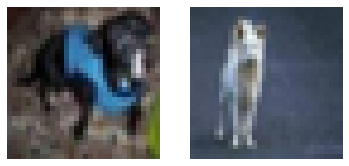

In [8]:
# Plot example '0' and '1'
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(sample_train[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(sample_train[50], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [9]:
print(X_train.targets)

[5 5 5 ... 7 7 7]


In [10]:
sample_train.shape

(1500, 32, 32, 3)

In [11]:
sample_train = sample_train.reshape(sample_train.shape[0],-1)

In [12]:
sample_test = sample_test.reshape(sample_test.shape[0],-1)

In [13]:
sample_train.shape

(1500, 3072)

In [14]:
# Reduce dimensions
n_dim = 3
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
#train_size = 100
#sample_train = sample_train[:train_size]
#label_train = label_train[:train_size]

#test_size = 20
#sample_test = sample_test[:test_size]
#label_test = label_test[:test_size]

# This is just to see the ecoding circuit

encode_map = ZZFeatureMap(feature_dimension=5, reps=2, entanglement='full', insert_barriers=True) encode_circuit = encode_map.bind_parameters(sample_train[0]) encode_circuit.decompose().draw(output='mpl')

In [15]:
zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='full', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

First we create and draw the circuit:

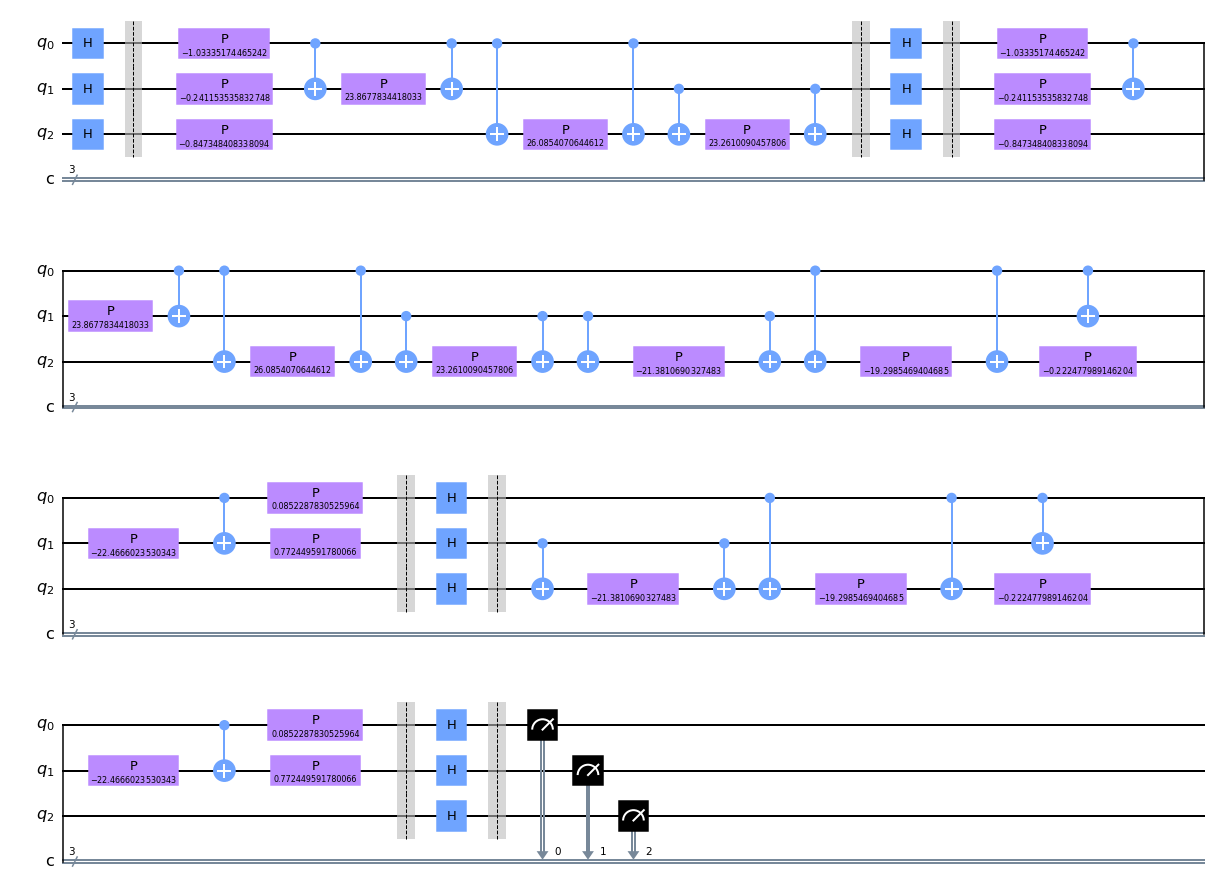

In [16]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

The parameters in the gates are a little difficult to read, but notice how the circuit is symmetrical, with one half encoding one of the data samples, the other half encoding the other.

We then simulate the circuit. We will use the qasm_simulator since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise.

In [17]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

The transition amplitude is the proportion of counts in the zero state:

In [18]:
print (counts)

{'001': 81, '100': 570, '110': 1297, '011': 505, '111': 1238, '010': 940, '000': 1611, '101': 1950}


In [19]:
#counts['0000']/sum(counts.values())
try:
    counts['0'*n_dim]/sum(counts.values())
except:
    print ('No')

This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explictly. 

Here we compute and plot the training and testing kernel matrices:

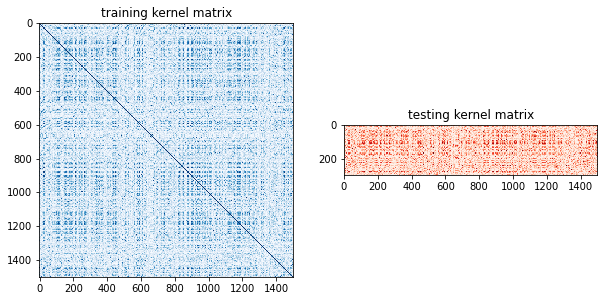

In [20]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

## Quantum Support Vector Classification


Introduced in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), the quantum kernel support vector classification algorithm consists of these steps:

<div><img src="attachment:qsvc.png" width="1200"></div> 

1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:

In [21]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.5066666666666667
